In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
def load_data(filename):
    df = pd.read_csv(filename)  # <-- Replace with your actual file path
    waveform_cols = [col for col in df.columns if col.startswith('t')]
    waveforms = df[waveform_cols].values  # shape (N, T)
    return df, waveforms

In [3]:
df, wf = load_data("../data/shiyan/run0006/alltraces.csv")

In [4]:
# Baseline correction
baseline_region = slice(20, 80)  # Adjust if needed

# Subtract the mean of baseline region from each waveform
wf = wf - wf[:, baseline_region].mean(axis=1, keepdims=True)


In [5]:
def plot_waveforms(df, waveforms, indices=None, n_random=None):
    if indices is None:
        if n_random is None:
            raise ValueError("You must provide either 'indices' or 'n_random'.")
        indices = np.random.choice(len(df), size=n_random, replace=False)

    plt.figure(figsize=(12, 6))
    for i in indices:
        plt.plot(waveforms[i], alpha=0.5)
    plt.title(f"{len(indices)} Waveforms (Baseline-Corrected)")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


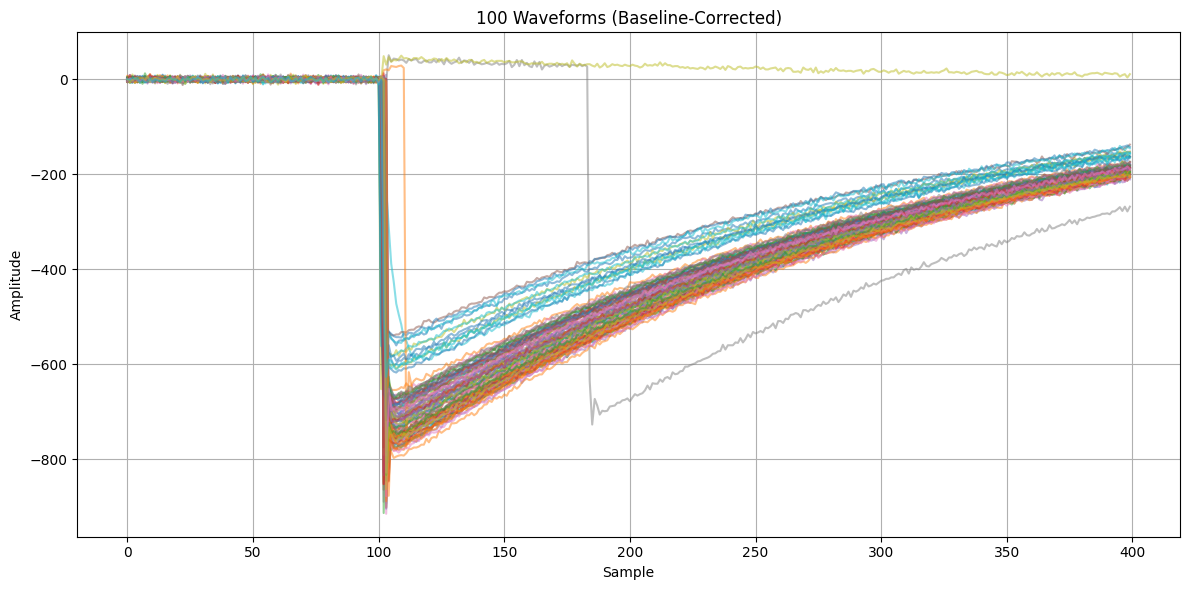

In [6]:
plot_waveforms(df, wf, n_random=100)

In [7]:
def compute_overlaps(df, waveforms):
    # Identify valid waveforms
    norms = np.linalg.norm(waveforms, axis=1)
    valid_mask = norms > 1e-8
    valid_waveforms = waveforms[valid_mask]

    # Average waveform and its normalized version
    avg = np.mean(valid_waveforms, axis=0)
    avg_norm = avg / np.linalg.norm(avg)

    # Normalize waveforms and compute cosine similarity
    normed = valid_waveforms / norms[valid_mask, np.newaxis]
    overlaps = normed @ avg_norm

    # Store overlap values in DataFrame
    df['overlap'] = np.nan
    df.loc[valid_mask, 'overlap'] = overlaps

    return df, avg, overlaps, valid_mask

In [8]:
def plot_strange_waveforms(df, waveforms, overlap_min=0.0, overlap_max=0.5, max_plots=10):
    # Select indices in the specified overlap range
    in_range = df[(df['overlap'] >= overlap_min) & (df['overlap'] <= overlap_max)].index

    print(f"Found {len(in_range)} waveforms with overlap in [{overlap_min}, {overlap_max}]")

    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(in_range):
        if i >= max_plots:
            break
        plt.plot(waveforms[idx], alpha=0.5)

    plt.title(f"Up to {max_plots} Waveforms in Overlap Range [{overlap_min}, {overlap_max}]")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [9]:
def plot_overlap_histogram(df, log_y=True, bins=100):
    overlaps = df['overlap'].dropna()  # remove NaNs if any

    plt.figure(figsize=(10, 5))
    plt.hist(overlaps, bins=bins)
    plt.xlabel('Cosine Similarity to Average')
    plt.ylabel('Count')
    plt.title('Overlap Distribution')

    if log_y:
        plt.yscale('log')

    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [10]:
df, avg, overlaps, valid_mask = compute_overlaps(df, wf)

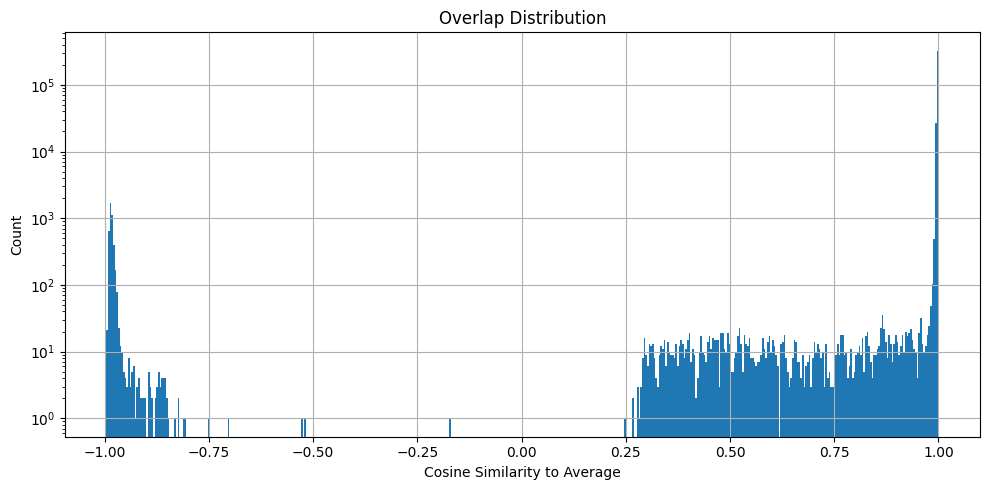

In [11]:
plot_overlap_histogram(df, log_y=True,bins=500)

Found 1628 waveforms with overlap in [0, 0.9]


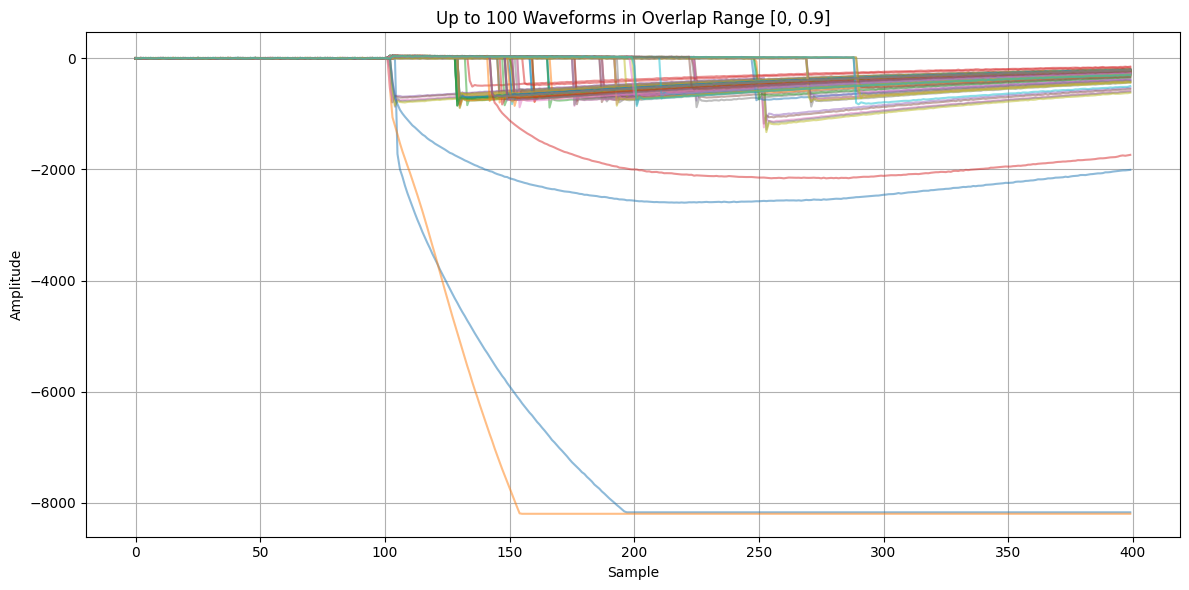

In [12]:
plot_strange_waveforms(df, wf, overlap_min=0, overlap_max=0.9, max_plots=100)

In [13]:
def get_strange_event_groups(df, overlap_min=0.0, overlap_max=0.5):
    # Step 1: Find event_IDs with strange waveforms
    strange_df = df[(df['overlap'] >= overlap_min) & (df['overlap'] <= overlap_max)]
    strange_event_ids = strange_df['event_ID'].unique()

    print(f"Found {len(strange_event_ids)} unique events with strange hits.")

    # Step 2: Collect all hits (rows) from those events
    grouped = df[df['event_ID'].isin(strange_event_ids)].copy()

    return grouped, strange_event_ids

In [14]:
grouped_df, strange_event_ids = get_strange_event_groups(df, overlap_min=0.25, overlap_max=0.9)

Found 449 unique events with strange hits.


In [15]:
for event_id in strange_event_ids[:5]:  # first 5 events
    hits = grouped_df[grouped_df['event_ID'] == event_id]
    print(f"\nEvent {event_id} has {len(hits)} hits:")
    display(hits[['layer', 'x', 'y', 'MWD', 'overlap']])


Event 100 has 4 hits:


,layer,x,y,MWD,overlap
106,1,2,0,141.424,0.997147
107,2,2,0,143.430,0.995113
108,3,2,0,185.603,0.990138
109,4,2,0,557.758,0.848857



Event 2391 has 5 hits:


,layer,x,y,MWD,overlap
1791,1,1,1,87.6684,0.998874
1792,2,1,1,93.5481,0.998495
1793,3,1,1,603.1150,0.865618
1794,4,1,1,100.2180,0.996196
1795,5,1,1,100.5240,0.998937



Event 4507 has 7 hits:


,layer,x,y,MWD,overlap
2920,1,0,1,91.45580,0.999098
2921,2,0,1,97.24210,0.999215
2922,3,0,1,92.26420,0.998694
2923,3,1,1,14.87720,0.850162
2924,4,0,1,92.43090,0.996645
2925,4,1,1,4.04789,0.836003
2926,5,0,1,100.01800,0.999053



Event 4664 has 8 hits:


,layer,x,y,MWD,overlap
3139,1,2,2,84.4388,0.998593
3140,1,0,2,26.7120,0.866538
3141,2,0,2,32.3943,0.870236
3142,2,2,2,91.9932,0.996364
3143,3,0,2,27.8773,0.864352
3144,3,2,2,91.3077,0.998697
3145,4,0,2,32.0973,0.869889
3146,5,0,2,33.7408,0.875990



Event 4841 has 10 hits:


,layer,x,y,MWD,overlap
3375,1,2,2,4.67345,0.790256
3376,1,3,0,86.75500,0.998006
3377,2,2,2,4.84191,0.790622
3378,2,3,0,93.99200,0.999095
3379,3,2,2,5.17050,0.789340
3380,3,3,0,99.06550,0.998995
3381,4,3,0,98.25870,0.998634
3382,4,2,2,5.31784,0.782189
3383,5,2,2,5.07365,0.786586
3384,5,3,0,95.98490,0.999013


In [16]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1 - lum) by the given amount.
    """
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = mcolors.to_rgb(c)
    return tuple(1 - (1 - channel) * amount for channel in c)

def show_event_waveforms(df, waveforms, strange_event_ids=None, event_id=None):
    if event_id is None:
        if strange_event_ids is None or len(strange_event_ids) == 0:
            raise ValueError("Provide either a specific event_id or a list of strange_event_ids.")
        event_id = np.random.choice(strange_event_ids)

    hits = df[df['event_ID'] == event_id]
    indices = hits.index.tolist()

    print(f"Showing event {event_id} with {len(indices)} hits:")
    display(hits[['layer', 'x', 'y', 'MWD', 'overlap']])

    # Assign a base color to each layer
    layers = hits['layer'].astype(int).unique()
    base_colors = {layer: cm.tab10(i % 10) for i, layer in enumerate(sorted(layers))}

    # Track number of times a layer has occurred
    layer_hit_count = {}

    plt.figure(figsize=(12, 6))
    for idx in indices:
        row = df.loc[idx]
        layer = int(row['layer'])
        layer_hit_count[layer] = layer_hit_count.get(layer, 0) + 1
        count = layer_hit_count[layer]

        # Lighten the base color slightly for each subsequent hit
        shade = 1.0 - (count - 1) * 0.4
        shade = max(shade, 0.4)  # prevent too light
        color = lighten_color(base_colors[layer], amount=shade)

        label = f"L{layer}, x{int(row['x'])}, y{int(row['y'])}"
        plt.plot(waveforms[idx], label=label, color=color, alpha=0.9)

    plt.title(f"Waveforms for Event {event_id}")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right', fontsize='small', ncol=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Showing event 282895 with 10 hits:


,layer,x,y,MWD,overlap
262275,1,2,1,82.38330,0.995725
262276,1,0,1,3.90049,0.496175
262277,2,0,1,5.71748,0.483132
262278,2,2,1,95.35460,0.998052
262279,3,0,1,4.60021,0.490877
262280,3,2,1,96.96760,0.997804
262281,4,2,1,99.75730,0.993980
262282,4,0,1,4.85519,0.491570
262283,5,2,1,99.40290,0.998072
262284,5,0,1,4.99328,0.492423


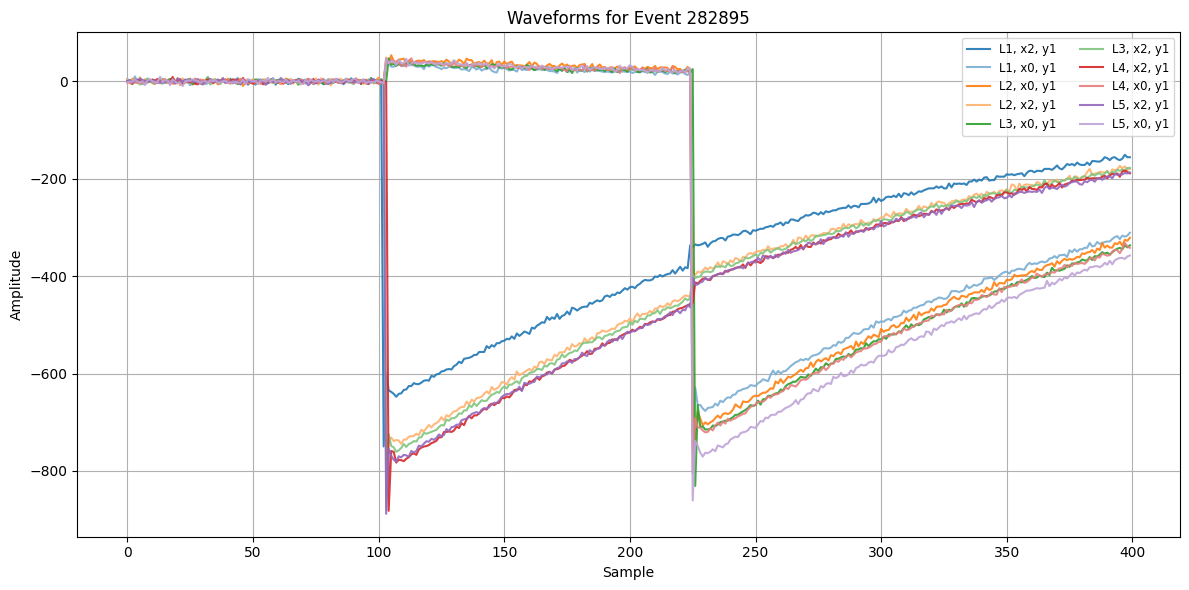

Showing event 358793 with 10 hits:


,layer,x,y,MWD,overlap
331159,1,1,2,81.49640,0.998600
331160,1,3,0,4.03018,0.599424
331161,2,1,2,86.61620,0.998213
331162,2,3,0,3.73853,0.596153
331163,3,1,2,88.74950,0.998898
331164,3,3,0,4.13303,0.596824
331165,4,3,0,4.35674,0.592380
331166,4,1,2,89.12580,0.998822
331167,5,1,2,94.02330,0.998157
331168,5,3,0,4.35247,0.594359


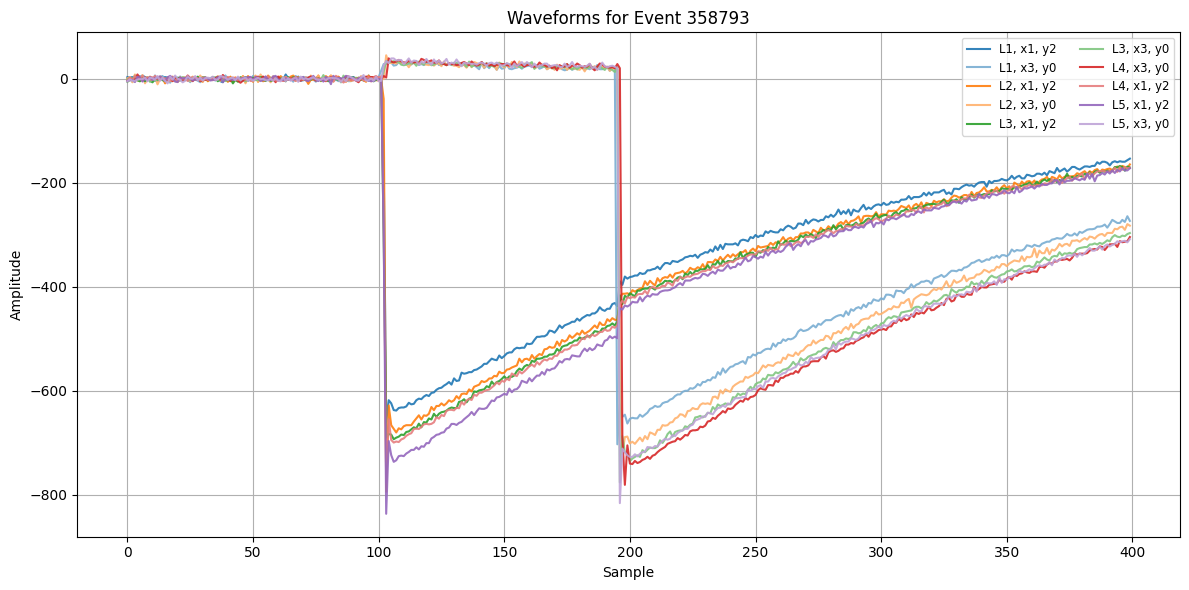

Showing event 172863 with 5 hits:


,layer,x,y,MWD,overlap
161087,1,1,2,88.7715,0.857994
161088,2,1,2,94.1611,0.859235
161089,3,1,2,95.6440,0.860101
161090,4,1,2,93.6968,0.853792
161091,5,1,2,101.6180,0.859240


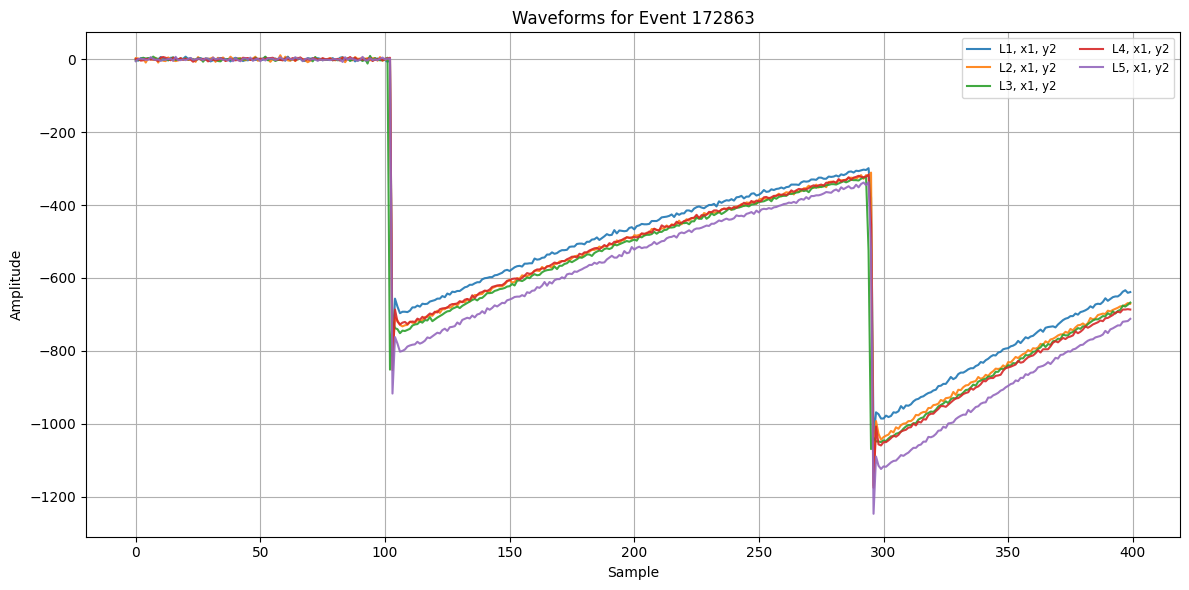

In [22]:
show_event_waveforms(df, wf, strange_event_ids=strange_event_ids)
show_event_waveforms(df, wf, event_id=358793)
show_event_waveforms(df, wf, event_id=172863)

In [19]:
from ipywidgets import interact, IntSlider, Dropdown
from IPython.display import display

In [20]:
def show_event_waveform_interactive(df, waveforms, strange_event_ids):
    def plot_event(event_id):
        hits = df[df['event_ID'] == event_id]
        indices = hits.index.tolist()

        print(f"\nEvent {event_id} with {len(indices)} hits:")
        display(hits[['layer', 'x', 'y', 'MWD', 'overlap']])

        # Prepare base colors for each layer
        layers = hits['layer'].astype(int).unique()
        base_colors = {layer: cm.tab10(i % 10) for i, layer in enumerate(sorted(layers))}
        layer_hit_count = {}

        plt.figure(figsize=(12, 6))
        for idx in indices:
            row = df.loc[idx]
            layer = int(row['layer'])
            layer_hit_count[layer] = layer_hit_count.get(layer, 0) + 1
            count = layer_hit_count[layer]
            shade = 1.0 - (count - 1) * 0.4
            shade = max(shade, 0.4)
            color = lighten_color(base_colors[layer], amount=shade)
            label = f"L{layer}, x{int(row['x'])}, y{int(row['y'])}"
            plt.plot(waveforms[idx], label=label, color=color, alpha=0.9)

        plt.title(f"Waveforms for Event {event_id}")
        plt.xlabel("Sample")
        plt.ylabel("Amplitude")
        plt.legend(loc='upper right', fontsize='small', ncol=2)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Create dropdown or slider based on number of events
    if len(strange_event_ids) <= 20:
        widget = Dropdown(options=sorted(strange_event_ids), description='Event ID')
    else:
        widget = IntSlider(min=0, max=len(strange_event_ids)-1, step=1, description='Index')
        def plot_event_index(i):
            plot_event(strange_event_ids[i])
        return interact(plot_event_index, i=widget)

    return interact(plot_event, event_id=widget)

In [21]:
show_event_waveform_interactive(df, wf, strange_event_ids)

interactive(children=(IntSlider(value=0, description='Index', max=448), Output()), _dom_classes=('widget-inter…

<function __main__.show_event_waveform_interactive.<locals>.plot_event_index(i)>

In [27]:
def compute_event_topology(df, event_ids=None):
    if event_ids is not None:
        df = df[df['event_ID'].isin(event_ids)]

    grouped = df.groupby('event_ID')

    event_summary = grouped.agg(
        multiplicity=('layer', 'count'),
        n_layers=('layer', lambda x: len(set(x))),
        n_coords=('x', lambda x: len(set(zip(x, df.loc[x.index, 'y']))))
    )

    return event_summary

In [30]:
def plot_topology_comparison(summary_all, summary_strange, density=False):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].hist(summary_all['multiplicity'], bins=range(1, 20), alpha=0.5, label='All', density=density)
    axs[0].hist(summary_strange['multiplicity'], bins=range(1, 20), alpha=0.5, label='Strange', density=density)
    axs[0].set_title("Multiplicity (Hits per Event)")
    axs[0].set_xlabel("Number of Hits")
    axs[0].set_ylabel("Density")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].hist(summary_all['n_layers'], bins=range(1, 8), alpha=0.5, label='All', density=density)
    axs[1].hist(summary_strange['n_layers'], bins=range(1, 8), alpha=0.5, label='Strange', density=density)
    axs[1].set_title("Unique Layers per Event")
    axs[1].set_xlabel("Number of Layers")
    axs[1].set_ylabel("Density")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

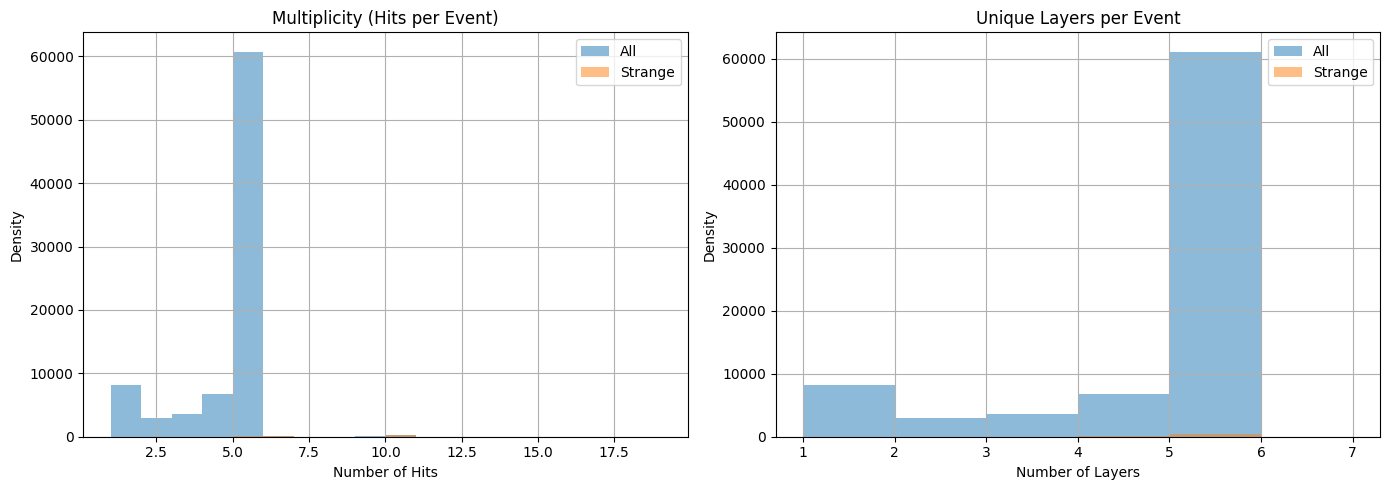

In [31]:
# Compute topology for all events
summary_all = compute_event_topology(df)

# Compute topology only for strange events
summary_strange = compute_event_topology(df, strange_event_ids)

# Plot comparison
plot_topology_comparison(summary_all, summary_strange)

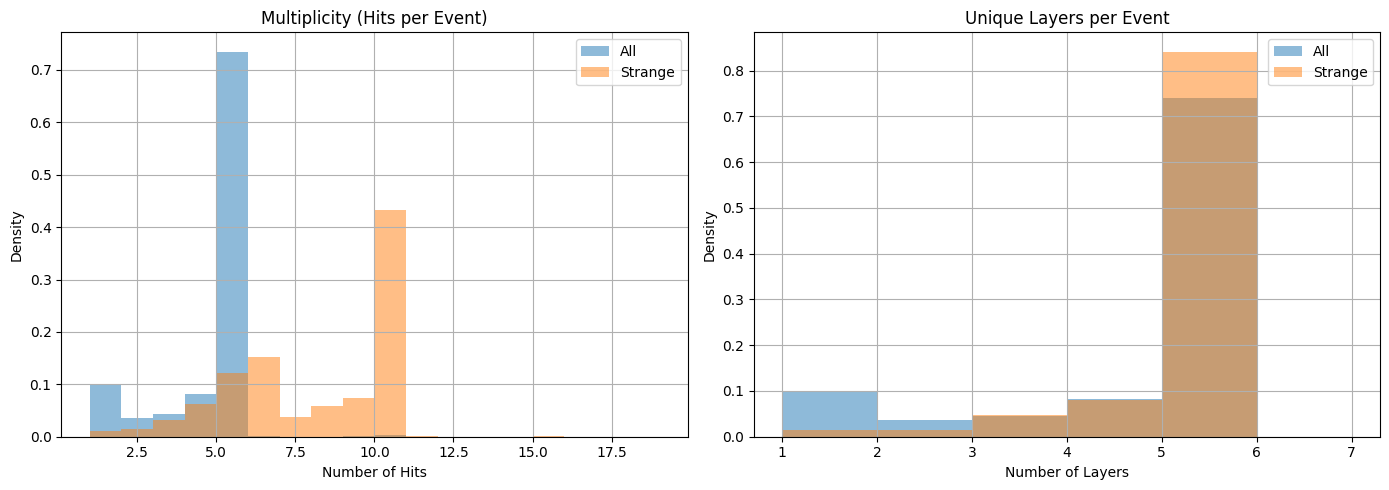

In [32]:
plot_topology_comparison(summary_all, summary_strange,density=True)

In [33]:
# Count total and strange events
total_events = df['event_ID'].nunique()
n_strange = len(set(strange_event_ids))

print(f"Total events: {total_events}")
print(f"Strange events: {n_strange}")
print(f"Fraction of strange events: {n_strange / total_events:.2%}")

Total events: 82647
Strange events: 449
Fraction of strange events: 0.54%
